<a href="https://colab.research.google.com/github/Kabongosalomon/Word-Embedding-Investigation/blob/master/One_hot_and_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import all package
from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import losses
from keras import metrics
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

import os

from gensim.models.keyedvectors import KeyedVectors

# One-hot encoding of words and characters

One-hot encoding is the most common, most basic way to turn a token into a vector.

It consists of associating a unique integer index with every word
and then turning this integer index i into a binary vector of size N (the size of the
vocabulary); the vector is all zeros except for the i th entry, which is 1.

## One-hot Word-level

In [2]:
import numpy as np

import string

!pip install ipdb
import ipdb # deb

from keras.preprocessing.text import Tokenizer

  Stored in directory: /root/.cache/pip/wheels/59/24/91/695211bd228d40fb22dff0ce3f05ba41ab724ab771736233f3
Successfully built ipdb


Using TensorFlow backend.


In [0]:
# Initial data: one entry per sample (in 
# this example, a sample is a sentence, 
# but it could be an entire document)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Builds an index of all tokens in the data
token_index = {}

for sample in samples:
    for word in sample.split(): # Tokenizes the samples via the split
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # Assigns a unique index to each unique word

# Vectorizes the samples. You’ll only
# consider the first max_length
# words in each sample.            
max_length = 10  # window

results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word) #; ipdb.set_trace()
        results[i, j, index] = 1.

In [0]:
token_index

{'The': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'the': 5,
 'mat.': 6,
 'dog': 7,
 'ate': 8,
 'my': 9,
 'homework.': 10}

In [0]:
results

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

## Character-level

In [0]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

characters = string.printable

token_index = dict(zip(range(1, len(characters) + 1), characters))

max_length = 50

results = np.zeros((len(samples), 
                    max_length, 
                    max(token_index.keys()) + 1))

for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)  #; ipdb.set_trace()
        results[i, j, index] = 1.

In [0]:
results

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

**Keras has built-in utilities for doing one-hot encoding of text at the word level
or character level**, starting from raw text data. 

We should use these utilities, because they take care of a number of important features such as stripping special characters from strings and only taking into account the N most common words in your dataset (a common restriction, to avoid dealing with very large input vector spaces).

## Use Keras build in function

### Word level

In [0]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=10)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


In [0]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [0]:
one_hot_results

array([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 1., 1.]])

In [0]:
word_index

{'the': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'mat': 5,
 'dog': 6,
 'ate': 7,
 'my': 8,
 'homework': 9}

In [0]:
# # Vectorizes the samples. You’ll only
# # consider the first max_length
# # words in each sample.            
# max_length = 10  # window

# results = np.zeros(shape=(len(samples),
#                           max_length,
#                           len(word_index) + 1))

# for i, sample in enumerate(samples):
#     for j, word in list(enumerate(sample.split()))[:max_length]:
#         index = word_index.get(word) #; ipdb.set_trace()
#         results[i, j, index] = 1.

In [0]:
# results

### Caracter level

In [0]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17 unique tokens.


In [0]:
sequences

[[2, 4, 3, 1, 9, 5, 2, 1, 10, 5, 2, 1, 6, 11, 1, 2, 4, 3, 1, 7, 5, 2, 8],
 [2,
  4,
  3,
  1,
  12,
  6,
  13,
  1,
  5,
  2,
  3,
  1,
  7,
  14,
  1,
  4,
  6,
  7,
  3,
  15,
  6,
  16,
  17,
  8]]

In [0]:
one_hot_results

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 1.]])

In [0]:
word_index

{' ': 1,
 't': 2,
 'e': 3,
 'h': 4,
 'a': 5,
 'o': 6,
 'm': 7,
 '.': 8,
 'c': 9,
 's': 10,
 'n': 11,
 'd': 12,
 'g': 13,
 'y': 14,
 'w': 15,
 'r': 16,
 'k': 17}

##  hashing trick

In [0]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
#         Hashes the word into a 
#         random integer index 
#         between 0 and 1,000
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

# Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense
word vectors, also called word embeddings. Whereas the vectors obtained through one-hot
encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same
dimensionality as the number of words in the vocabulary), word embeddings are low-
dimensional floating-point vectors (that is, dense vectors, as opposed to sparse vec-
tors);

Unlike the  word vectors  obtained  via one-hot  encoding,  **word embeddings  are  learned  from  data**. It’s common  to  see  word  embeddings  that are
256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large
vocabularies. 

On the other hand, one-hot encoding words generally leads to vectors
that are 20,000-dimensional or greater (capturing a vocabulary of 20,000 tokens, in
this case). 

So, word embeddings *pack more information into far fewer dimensions*.

There are two ways to obtain word embeddings:
- Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
-  Load into your model word embeddings that were pretrained using a different machinelearning task than the one you’re trying to solve.

Word embeddings are meant to *map human language into a geometric space*. For instance, in a reasonable embedding space, you would expect synonyms to be embedded into similar word vectors; and in general, you would expect the geometric distance (such as L2 distance) between any two word vectors to relate to the semantic distance between the associated words (words meaning different things are embedded at points far away from
each other, whereas related words are closer). 

In addition to distance, you may want
specific directions in the embedding space to be meaningful.

## DataSet IMDB

In [0]:
max_features = 10000
# maxlen = 20

maxlen = 500

# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
(x_train, y_train), (x_test, y_test) = imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


In [0]:
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [0]:
x_train.shape

(25000, 500)

In [0]:
x_test.shape

(25000, 500)

In [0]:
model = Sequential()
# Specifies the maximum input length to the 
# Embedding layer so you can later flatten the 
# embedded inputs. After the Embedding layer, 
# the activations have shape (samples, maxlen, 8).
model.add(Embedding(10000, 8, input_length=x_train.shape[1]))
# Flattens the 3D tensor of 
# embeddings into a 2D 
# tensor of shape (samples, maxlen * 8)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 8)            80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4001      
Total params: 84,001
Trainable params: 84,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train, y_train,
          epochs=10, batch_size=32,
          validation_split=0.2) # Split validation of 20% automatically)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 227us/step - loss: 0.5851 - acc: 0.7096 - val_loss: 0.3946 - val_acc: 0.8434
Epoch 2/10
20000/20000 [==============================] - 2s 89us/step - loss: 0.2997 - acc: 0.8853 - val_loss: 0.2872 - val_acc: 0.8828
Epoch 3/10
20000/20000 [==============================] - 2s 86us/step - loss: 0.2219 - acc: 0.9140 - val_loss: 0.2784 - val_acc: 0.8866
Epoch 4/10
20000/20000 [==============================] - 2s 87us/step - loss: 0.1852 - acc: 0.9295 - val_loss: 0.2687 - val_acc: 0.8926
Epoch 5/10
20000/20000 [==============================] - 2s 85us/step - loss: 0.1598 - acc: 0.9406 - val_loss: 0.2724 - val_acc: 0.8912
Epoch 6/10
20000/20000 [==============================] - 2s 86us/step - loss: 0.1402 - acc: 0.9485 - val_loss: 0.2788 - val_acc: 0.8912
Epoch 7/10
20000/20000 [==============================] - 2s 87us/step - loss: 0

In [0]:
result = model.evaluate(x_test, y_test)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],2)))

25000/25000 [==============================] - 1s 35us/step
Metric  loss : 0.34
Metric  acc : 0.88


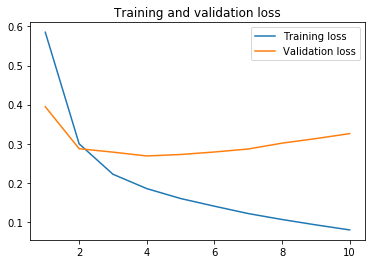

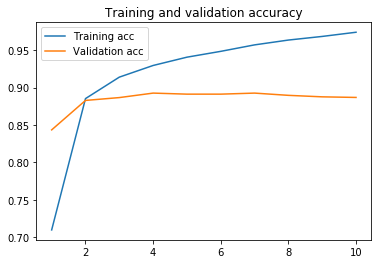

In [0]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

We can see that our model start well but quickly overfit.

We get to a validation accuracy of ~76%, on enseen example, which is pretty good considering that we’re only looking at the first 20 words in every review. But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that **treats  each  word  in  the  input  sequence  separately,  without  considering  inter-word relationships and sentence structure** (for example, this model would likely treat both “this movie is a bomb” and “this movie is the bomb” as being negative reviews). 

Let look at how to capture those *inter-word relationships* 

There exist 2 main approach :

1. adding a recurrent layers or
2. adding a 1D convolutional layers on top of the embedded  sequences  to  learn  features  that  take  into  account  each  sequence  as  a  whole.

## USING PRETRAINED WORD EMBEDDINGS

First, head to http://mng.bz/0tIo and download the raw IMDB dataset. Uncompress it.

Now, let’s collect the individual training reviews into a list of strings, one string per review. We’ll also collect the review labels (positive/negative) into a labels list.

In [12]:
link = "https://drive.google.com/file/d/1smGRs2g2HoI6VSvonoZmWKzXOP6uPUaW/view?usp=sharing"

_, id_t = link.split('d/')

id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

1smGRs2g2HoI6VSvonoZmWKzXOP6uPUaW


In [13]:
!ls

aclImdb.zip  adc.json  crawl-300d-2M.vec  sample_data


In [0]:
!unzip aclImdb.zip

In [16]:
!ls


aclImdb  aclImdb.zip  adc.json	crawl-300d-2M.vec  __MACOSX  sample_data


In [0]:
# imdb_dir = './data/aclImdb'
imdb_dir = './aclImdb'

train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [18]:
np.unique(labels)

array([0, 1])

In [19]:
type(labels)

list

In [20]:
type(texts)

list

### TOKENIZING THE DATA

Let’s vectorize the text and prepare a training and validation split. Pretrained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise,
task-specific embeddings are likely to outperform them), we’ll add the following twist: restricting the training data to the first $200 samples$. So you’ll learn to classify movie reviews after looking at just 200 examples.

In [0]:
# Cuts off reviews after 100 words
# maxlen = 100
maxlen = 500

# Trains on 200 samples
# training_samples = 200
training_samples = 15000

# Validates on 10,000 samples
validation_samples = 10000

# Considers only the top 
# 10,000 words in the dataset
max_words = 10000

# tokenizer = Tokenizer(num_words=max_words)
tokenizer = Tokenizer()

tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [35]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splits the data into a training set and a 
# validation set, but first shuffles the data, 
# because you’re starting with data in which 
# samples are ordered (all negative first, then 
# all positive) 
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 500)
Shape of label tensor: (25000,)


In [36]:
#Explore the data structure using basic python commands
print("Type of the Dataset:",type(x_train))
print("Shape of training data :",x_train.shape)
print("Shape of training labels :",y_train.shape)
print("Shape of testing data :",x_val.shape)
print("Shape of testing labels :",y_val.shape)

Type of the Dataset: <class 'numpy.ndarray'>
Shape of training data : (15000, 500)
Shape of training labels : (15000,)
Shape of testing data : (10000, 500)
Shape of testing labels : (10000,)


In [0]:
x_train[:5]

array([[    0,     0,     0, ...,   287,     3, 22583],
       [    0,     0,     0, ...,    36,     1,  3474],
       [    0,     0,     0, ...,    52,    52,    73],
       [    0,     0,     0, ...,  1121,    17,   123],
       [    0,     0,     0, ...,    11,   183,  2385]], dtype=int32)

##  GLOVE WORD EMBEDDINGS

Go  to  https://nlp.stanford.edu/projects/glove,  and  download  the  precomputed
embeddings from 2014 English Wikipedia.  It’s an 822 MB zip file called glove.6B.zip,
containing  100-dimensional  embedding  vectors  for  400,000  words  (or  nonword
tokens). Unzip it. 

In [0]:
# PREPROCESSING THE EMBEDDINGS
glove_dir = './data/glove.6B'
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Well, we have axactly $400.000$ words as expected, of dimension $100$

In [0]:
embeddings_index['hello']

array([ 0.26688  ,  0.39632  ,  0.6169   , -0.77451  , -0.1039   ,
        0.26697  ,  0.2788   ,  0.30992  ,  0.0054685, -0.085256 ,
        0.73602  , -0.098432 ,  0.5479   , -0.030305 ,  0.33479  ,
        0.14094  , -0.0070003,  0.32569  ,  0.22902  ,  0.46557  ,
       -0.19531  ,  0.37491  , -0.7139   , -0.51775  ,  0.77039  ,
        1.0881   , -0.66011  , -0.16234  ,  0.9119   ,  0.21046  ,
        0.047494 ,  1.0019   ,  1.1133   ,  0.70094  , -0.08696  ,
        0.47571  ,  0.1636   , -0.44469  ,  0.4469   , -0.93817  ,
        0.013101 ,  0.085964 , -0.67456  ,  0.49662  , -0.037827 ,
       -0.11038  , -0.28612  ,  0.074606 , -0.31527  , -0.093774 ,
       -0.57069  ,  0.66865  ,  0.45307  , -0.34154  , -0.7166   ,
       -0.75273  ,  0.075212 ,  0.57903  , -0.1191   , -0.11379  ,
       -0.10026  ,  0.71341  , -1.1574   , -0.74026  ,  0.40452  ,
        0.18023  ,  0.21449  ,  0.37638  ,  0.11239  , -0.53639  ,
       -0.025092 ,  0.31886  , -0.25013  , -0.63283  , -0.0118

Next, you’ll build an embedding matrix that you can load into an Embedding layer. It
must be a matrix of shape $(max\_words, embedding_dim=1000)$, where each entry i contains
the embedding_dim-dimensional vector for the word of index i in the reference word
index (built during tokenization). Note that index 0 isn’t supposed to stand for any
word or token—it’s a placeholder

In [0]:
embedding_dim = 100
# Cuts off reviews after 100 words
maxlen = 100

# Considers only the top 
# 10,000 words in the dataset
max_words = 10000

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
#         ipdb.set_trace()
        embedding_vector = embeddings_index.get(word)
        # cheking that th eword exist in the embedding dictionary
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix[-1] # looking at the last element

array([-0.17381001, -0.037609  ,  0.068837  , -1.04799998,  0.81278002,
        0.26355001,  0.41485   ,  0.018956  , -0.40834999,  0.31979999,
       -0.07748   , -0.27023   ,  1.21099997, -0.101     ,  0.16656999,
        0.56098998,  1.14040005,  0.25082999,  0.36381999, -0.70122999,
       -0.97337002, -0.2264    , -0.30101001,  0.43255001,  0.43430999,
        0.38058999,  0.062135  ,  0.17827   , -0.36430001, -0.78675002,
        0.84675002,  1.12370002, -0.37193999,  0.36816999,  0.057344  ,
       -0.013778  , -0.34051999, -0.50598001, -0.31538001, -0.18312   ,
        1.01400006, -0.42223001,  0.10368   ,  0.25560001, -0.25810999,
        0.29519001, -0.29216999,  0.43917999, -0.36399999, -0.74561   ,
       -0.094103  ,  0.50668001, -0.047155  ,  1.07140005, -0.28018999,
       -1.69490004, -0.38648999,  0.32921001,  0.76716   , -0.30908   ,
       -0.12284   ,  0.82014   ,  0.043673  ,  0.26510999,  0.60667002,
       -0.27529001, -0.61680001,  0.062825  ,  0.013927  ,  0.04

In [0]:
embedding_matrix.shape

(10000, 100)

In [0]:
print(f"Max_words = {max_words}, \nEmbedding_dim = {embedding_dim} and \nInput_length = {maxlen}")

Max_words = 10000, 
Embedding_dim = 100 and 
Input_length = 100


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________


The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is
the word vector meant to be associated with index i. Simple enough. Load the GloVe
matrix you prepared into the Embedding layer, the first layer in the model.

In [0]:
model.layers[0].set_weights([embedding_matrix])
#  freeze the Embedding layer
# the pretrained parts shouldn’t
# be updated during training, to avoid forgetting what they already know
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 0.7725 - acc: 0.4550 - val_loss: 0.7044 - val_acc: 0.4977
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4366 - acc: 0.8500 - val_loss: 0.8776 - val_acc: 0.5018
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3288 - acc: 0.8450 - val_loss: 0.7767 - val_acc: 0.4967
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1073 - acc: 1.0000 - val_loss: 0.7687 - val_acc: 0.5038
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0450 - acc: 1.0000 - val_loss: 1.0700 - val_acc: 0.5008
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0295 - acc: 1.0000 - val_loss: 0.7990 - val_acc: 0.5011
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0120 - acc: 1.0000 - val_loss: 0.8184 - val_acc: 0.5004
Epoch 8/10
200/200 [=======

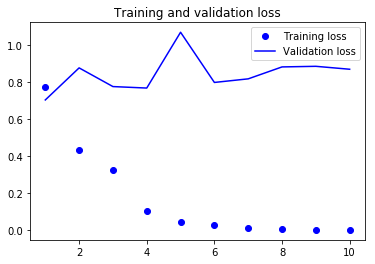

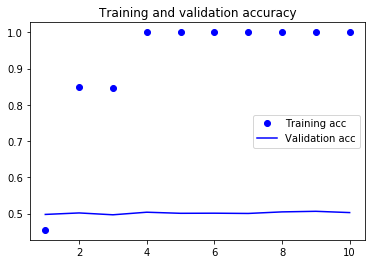

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

## WORD2VEC EMBEDDINGS

Developed  by  Tomas  Mikolov  at  Google  in  2013.  Word2vec (https://code.google.com/archive/p/word2vec)
dimensions capture specific semantic properties

In [0]:
link = "https://drive.google.com/file/d/13NmrtF-HoGmdv_m3Ld4eGVTbIekOcNi_/view?usp=sharing"

In [0]:
_, id_t = link.split('d/')

id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

13NmrtF-HoGmdv_m3Ld4eGVTbIekOcNi_


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [0]:
!ls

aclImdb      GoogleNews-vectors-negative300.bin  sample_data
aclImdb.zip  __MACOSX				 wiki-news-300d-1M.vec
adc.json     pre_trained_word2vec_model.h5	 wiki-news-300d-1M.vec.zip


In [0]:
gensim_w2v = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [0]:
print('hello =', gensim_model['hello'])

hello = [-0.05419922  0.01708984 -0.00527954  0.33203125 -0.25       -0.01397705
 -0.15039062 -0.265625    0.01647949  0.3828125  -0.03295898 -0.09716797
 -0.16308594 -0.04443359  0.00946045  0.18457031  0.03637695  0.16601562
  0.36328125 -0.25585938  0.375       0.171875    0.21386719 -0.19921875
  0.13085938 -0.07275391 -0.02819824  0.11621094  0.15332031  0.09082031
  0.06787109 -0.0300293  -0.16894531 -0.20800781 -0.03710938 -0.22753906
  0.26367188  0.012146    0.18359375  0.31054688 -0.10791016 -0.19140625
  0.21582031  0.13183594 -0.03515625  0.18554688 -0.30859375  0.04785156
 -0.10986328  0.14355469 -0.43554688 -0.0378418   0.10839844  0.140625
 -0.10595703  0.26171875 -0.17089844  0.39453125  0.12597656 -0.27734375
 -0.28125     0.14746094 -0.20996094  0.02355957  0.18457031  0.00445557
 -0.27929688 -0.03637695 -0.29296875  0.19628906  0.20703125  0.2890625
 -0.20507812  0.06787109 -0.43164062 -0.10986328 -0.2578125  -0.02331543
  0.11328125  0.23144531 -0.04418945  0.108398

In [0]:
# gensim_model.save_word2vec_format('./data/GoogleNews-vectors-negative300.txt', binary=False)

In [0]:
type(gensim_model['hello'])

numpy.ndarray

In [0]:
gensim_model['hello'].shape

(300,)

In [0]:
gensim_model["0"].shape

(300,)

In [0]:
type(gensim_model['0'])

numpy.ndarray

In [0]:
# 3000000 words
len(gensim_model.vocab)

3000000

In [0]:
embedding_dim = 300

# Cuts off reviews after 100 words
maxlen = 100

# Considers only the top 
# 10,000 words in the dataset
max_words = 10000

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
#         ipdb.set_trace()
        if word not in gensim_model.vocab:
            pass;
        else :
            embedding_vector = gensim_model[word]
        # cheking that th eword exist in the embedding dictionary
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix[-1]

array([ 0.08642578,  0.14746094,  0.01452637,  0.3046875 , -0.12597656,
       -0.10058594,  0.03491211, -0.31054688,  0.28515625, -0.08496094,
       -0.04711914, -0.07617188, -0.22265625, -0.00549316, -0.38476562,
       -0.04394531, -0.31640625, -0.00579834, -0.00379944, -0.20019531,
       -0.05981445,  0.58203125,  0.15429688, -0.08447266, -0.17285156,
       -0.01757812, -0.11425781,  0.11962891,  0.24023438, -0.1953125 ,
        0.06494141,  0.14355469, -0.10986328,  0.04248047,  0.48046875,
        0.09179688,  0.3046875 ,  0.29296875,  0.20507812, -0.26367188,
       -0.23730469,  0.02746582, -0.3515625 , -0.00424194,  0.31054688,
       -0.23144531,  0.00309753, -0.01672363,  0.3203125 ,  0.33984375,
       -0.25390625, -0.03491211,  0.30273438, -0.30664062,  0.16601562,
       -0.0559082 ,  0.11181641, -0.19921875,  0.16503906, -0.15039062,
       -0.02893066,  0.0324707 , -0.3125    , -0.00276184, -0.15917969,
       -0.06933594, -0.04956055,  0.23339844,  0.03613281,  0.38

In [0]:
print(f"Max_words = {max_words}, \nEmbedding_dim = {embedding_dim} and \nInput_length = {maxlen}")

Max_words = 10000, 
Embedding_dim = 300 and 
Input_length = 100


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                960032    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.layers[0].set_weights([embedding_matrix])
#  freeze the Embedding layer
# the pretrained parts shouldn’t
# be updated during training, to avoid forgetting what they already know
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_word2vec_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 1.1617 - acc: 0.4800 - val_loss: 0.6939 - val_acc: 0.5022
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.5824 - acc: 0.6500 - val_loss: 1.0086 - val_acc: 0.5022
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.4327 - acc: 0.8500 - val_loss: 0.8622 - val_acc: 0.5022
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2525 - acc: 0.9750 - val_loss: 0.7836 - val_acc: 0.4971
Epoch 5/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1372 - acc: 1.0000 - val_loss: 1.0069 - val_acc: 0.5007
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0788 - acc: 1.0000 - val_loss: 0.7669 - val_acc: 0.4963
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0417 - acc: 1.0000 - val_loss: 0.7719 - val_acc: 0.5045
Epoch 8/10
200/200 [=

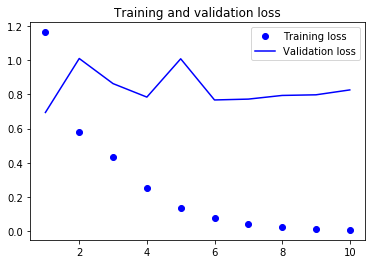

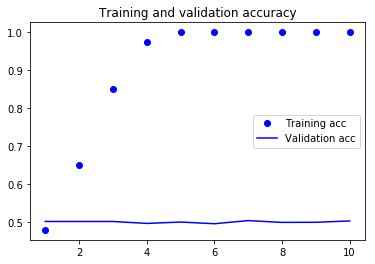

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Fasttext

https://fasttext.cc/docs/en/english-vectors.html

In [4]:
# crawl-300d-2M.vec.zip: 2 million word vectors trained on Common Crawl (600B tokens).

link = "https://drive.google.com/file/d/1jkJmSpRVZr_V2vGGkLmoEio6eY2Q2el-/view?usp=sharing"

_, id_t = link.split('d/')


id = id_t.split('/')[0]
print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

1jkJmSpRVZr_V2vGGkLmoEio6eY2Q2el-
    100% |████████████████████████████████| 993kB 22.9MB/s 


In [24]:
!ls

aclImdb  aclImdb.zip  adc.json	crawl-300d-2M.vec  __MACOSX  sample_data


In [6]:
!unzip crawl-300d-2M.vec.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [0]:
!rm crawl-300d-2M.vec.zip

In [15]:
!ls

aclImdb  aclImdb.zip  adc.json	crawl-300d-2M.vec  __MACOSX  sample_data


In [0]:
gensim_fasttext = KeyedVectors.load_word2vec_format('./crawl-300d-2M.vec')


In [28]:
gensim_fasttext['and']

array([-1.081e-01,  1.910e-02,  3.540e-02,  1.270e-02,  6.640e-02,
       -1.260e-02, -1.882e-01,  6.310e-02, -2.306e-01,  9.500e-03,
        9.170e-02,  1.513e-01,  5.580e-02, -6.430e-02, -2.880e-02,
       -4.470e-02,  1.603e-01,  6.130e-02,  3.490e-02, -5.780e-02,
        3.000e-04, -1.399e-01,  1.630e-02, -4.190e-02, -4.870e-02,
        5.700e-03,  1.700e-03, -2.680e-02, -1.700e-02,  1.045e-01,
        8.150e-02, -6.000e-03,  6.350e-02, -1.710e-01,  2.760e-02,
       -2.300e-02,  8.240e-02,  3.040e-02, -1.595e-01,  8.510e-02,
       -5.560e-02,  3.290e-02, -9.210e-02,  1.960e-02, -4.040e-02,
        3.610e-02, -8.430e-02,  1.014e-01, -3.930e-02, -1.805e-01,
       -7.300e-03,  2.247e-01, -6.210e-02, -5.750e-02, -3.160e-02,
        1.980e-02,  6.020e-02,  1.312e-01, -1.278e-01,  1.770e-02,
       -6.000e-02, -2.904e-01, -4.650e-02, -1.078e-01, -7.010e-02,
       -4.970e-02, -1.102e-01,  1.560e-02, -5.950e-02,  7.620e-02,
        2.638e-01,  3.530e-02,  7.450e-02,  3.610e-02, -5.610e

In [29]:
gensim_fasttext['hsyo']

KeyError: ignored

In [30]:
gensim_fasttext['hello'].shape

(300,)

In [32]:
type(gensim_fasttext['0'])

numpy.ndarray

In [33]:
# 2000000 words
len(gensim_fasttext.vocab)

1999995

In [0]:
embedding_dim = gensim_fasttext['hello'].shape[0]

# Cuts off reviews after 100 words
# maxlen = 500

# Considers only the top 
# 10,000 words in the dataset
# max_words = 10000

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
#         ipdb.set_trace()
        if word not in gensim_model.vocab:
            pass;
        else :
            embedding_vector = gensim_model[word]
        # cheking that th eword exist in the embedding dictionary
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

In [38]:
embedding_matrix[-1]

array([ 0.145     , -0.38229999,  0.22849999, -0.43020001,  0.002     ,
       -0.1035    ,  0.0786    , -0.0783    ,  0.25830001, -0.1183    ,
       -0.0126    ,  0.57870001, -0.0334    ,  0.1903    , -0.0063    ,
        0.21160001,  0.0955    , -0.58200002,  0.1857    , -0.56379998,
       -0.1648    , -0.24869999,  0.2045    , -0.2617    , -0.90850002,
       -0.50419998,  0.2016    , -0.1       , -0.13150001, -0.2221    ,
       -0.0561    ,  0.0122    , -0.122     ,  0.0241    ,  0.039     ,
        0.0712    ,  0.0503    , -0.1353    ,  0.59960002,  0.072     ,
       -0.35260001, -0.0226    , -0.3143    , -0.0589    , -0.0439    ,
       -0.3872    ,  0.3457    , -0.39219999,  0.3204    ,  0.0828    ,
       -0.26679999,  0.1955    ,  0.87970001,  0.4411    ,  0.3364    ,
       -0.0469    ,  0.21780001, -0.13689999, -0.0319    ,  0.1604    ,
       -0.064     , -0.0272    , -0.0692    ,  0.2339    , -0.3716    ,
        0.0802    ,  0.0832    ,  0.0105    ,  0.0396    , -0.51

In [39]:
print(f"Max_words = {max_words}, \nEmbedding_dim = {embedding_dim} and \nInput_length = {maxlen}")

Max_words = 10000, 
Embedding_dim = 300 and 
Input_length = 500


In [40]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
# model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Embedding(max_words, embedding_dim, input_length=x_train.shape[1]))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 150000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4800032   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 7,800,065
Trainable params: 7,800,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.layers[0].set_weights([embedding_matrix])
#  freeze the Embedding layer
# the pretrained parts shouldn’t
# be updated during training, to avoid forgetting what they already know
model.layers[0].trainable = False

In [42]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
#                     validation_data=(x_val, y_val))

# model.save_weights('pre_trained_word2vec_model.h5')

Instructions for updating:
Use tf.cast instead.
Train on 12000 samples, validate on 3000 samples
Epoch 1/10
12000/12000 [==============================] - 3s 276us/step - loss: 0.7082 - acc: 0.5022 - val_loss: 0.6940 - val_acc: 0.4833
Epoch 2/10
12000/12000 [==============================] - 2s 171us/step - loss: 0.6716 - acc: 0.5902 - val_loss: 0.7348 - val_acc: 0.5143
Epoch 3/10
12000/12000 [==============================] - 2s 171us/step - loss: 0.3665 - acc: 0.8493 - val_loss: 0.9533 - val_acc: 0.4950
Epoch 4/10
12000/12000 [==============================] - 2s 170us/step - loss: 0.1129 - acc: 0.9703 - val_loss: 1.2371 - val_acc: 0.5130
Epoch 5/10
12000/12000 [==============================] - 2s 172us/step - loss: 0.0290 - acc: 0.9953 - val_loss: 2.2106 - val_acc: 0.5137
Epoch 6/10
12000/12000 [==============================] - 2s 170us/step - loss: 0.0159 - acc: 0.9977 - val_loss: 2.1194 - val_acc: 0.5077
Epoch 7/10
12000/12000 [==============================] - 2s 171us/step - l

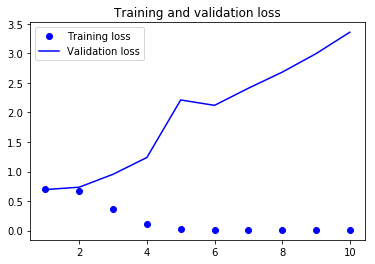

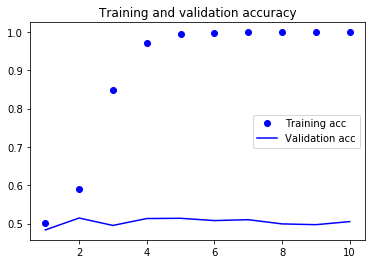

In [43]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

## without pretrained word embeddings

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                960032    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 5s 24ms/step - loss: 0.7007 - acc: 0.5050 - val_loss: 0.6969 - val_acc: 0.4998
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.3045 -

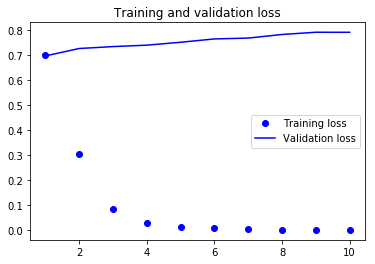

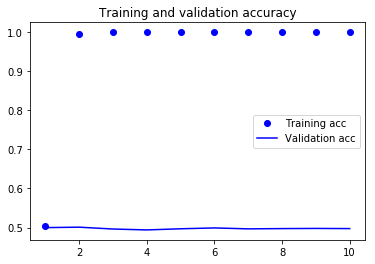

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
# plt.figure(figsize=(9,8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

So far Word2Vec look to be better than others for few training example, but I'm planning to continue studying as I increase the training sample size and will try also the 1D conv layer as well as recurent network

 So in this case, pretrained word embeddings
outperform jointly learned embeddings.

In [0]:
imdb_dir = './data/aclImdb'

train_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)

x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [0]:
model.load_weights('pre_trained_glove_model.h5')
result = model.evaluate(x_test, y_test)
for i in range(len(model.metrics_names)):
     print("Metric ",model.metrics_names[i],":", str(round(result[i],2)))

25000/25000 [==============================] - 4s 159us/step
Metric  loss : 0.7
Metric  acc : 0.51
